In [1]:
# Cell 1: Copy‐in your data‐building functions (or save them as `model/data_builder.py` and import)
import pandas as pd
import numpy as np
import requests
import cv2

from model import (
    SETINFO,
    INITIAL_WIDTH,
    INITIAL_HEIGHT,
    HARD_CODED_WIDTH,
    HARD_CODED_HEIGHT,
    REDUCED_SET,
)

from model.util import download_image, crop_corners, make_record, create_dataset, reduce_dataset, reduce_side


In [2]:
# Cell 2: Build the full corner‐crop DataFrame
df_full = create_dataset()
print("Total records:", len(df_full))


▶️ Processing set dv1 (21 cards)
▶️ Processing set swsh9 (186 cards)
▶️ Processing set swsh45 (73 cards)
▶️ Processing set swsh6 (233 cards)
▶️ Processing set swsh12pt5 (160 cards)
▶️ Processing set xy1 (146 cards)
▶️ Processing set xy2 (110 cards)
⚠️ Failed to fetch https://images.pokemontcg.io/xy2/110_hires.png
▶️ Processing set xy3 (114 cards)
⚠️ Failed to fetch https://images.pokemontcg.io/xy3/114_hires.png
▶️ Processing set g1 (117 cards)
⚠️ Failed to fetch https://images.pokemontcg.io/g1/84_hires.png
⚠️ Failed to fetch https://images.pokemontcg.io/g1/85_hires.png
⚠️ Failed to fetch https://images.pokemontcg.io/g1/86_hires.png
⚠️ Failed to fetch https://images.pokemontcg.io/g1/87_hires.png
⚠️ Failed to fetch https://images.pokemontcg.io/g1/88_hires.png
⚠️ Failed to fetch https://images.pokemontcg.io/g1/89_hires.png
⚠️ Failed to fetch https://images.pokemontcg.io/g1/90_hires.png
⚠️ Failed to fetch https://images.pokemontcg.io/g1/91_hires.png
⚠️ Failed to fetch https://images.pokemo

In [3]:
df_full.head(10)

,corner,position,set_id,set_name
0,"[[221, 221, 221, 221, 221, 221, 221, 221, 221,...",left,no,no
1,"[[83, 82, 82, 85, 83, 79, 82, 82, 79, 82, 90, ...",right,dv1,Dragon Vault
2,"[[221, 221, 221, 221, 221, 221, 221, 221, 221,...",left,no,no
3,"[[83, 82, 82, 85, 83, 79, 82, 82, 79, 82, 90, ...",right,dv1,Dragon Vault
4,"[[221, 221, 221, 221, 221, 221, 221, 221, 221,...",left,no,no
5,"[[83, 82, 82, 85, 83, 79, 82, 82, 79, 82, 90, ...",right,dv1,Dragon Vault
6,"[[221, 221, 221, 221, 221, 221, 221, 221, 221,...",left,no,no
7,"[[83, 82, 82, 85, 83, 79, 82, 82, 79, 82, 90, ...",right,dv1,Dragon Vault
8,"[[221, 221, 221, 221, 221, 221, 221, 221, 221,...",left,no,no
9,"[[83, 82, 82, 85, 83, 79, 82, 82, 79, 82, 90, ...",right,dv1,Dragon Vault


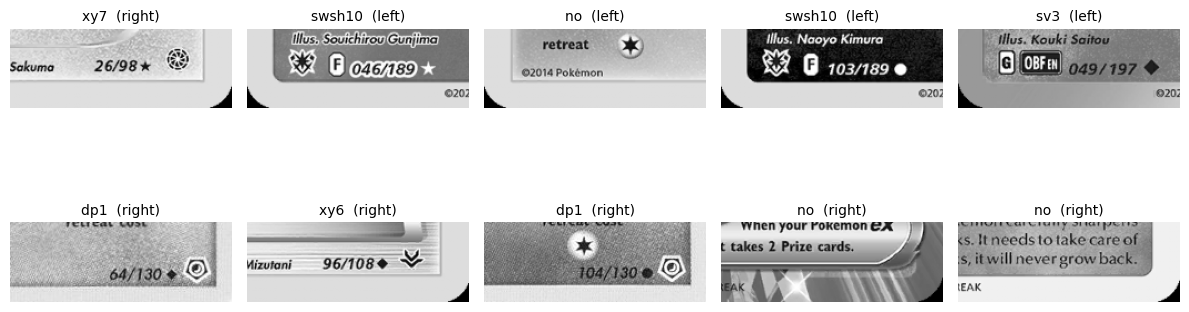

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1) Load the full dataset you created
#    (or call create_dataset() to get the DataFrame directly)
df = pd.read_json("raw_data/full_corners.json")

# 2) Convert each “corner” from list back into a NumPy array
df['corner'] = df['corner'].apply(lambda lst: np.array(lst, dtype=np.uint8))

# 3) Sample 10 random examples
sample = df.sample(10, random_state=42).reset_index(drop=True)

# 4) Plot them in a 2×5 grid
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
for ax, (_, row) in zip(axes.flat, sample.iterrows()):
    ax.imshow(row['corner'], cmap='gray')
    ax.set_title(f"{row['set_id']}  ({row['position']})", fontsize=10)
    ax.axis('off')

plt.tight_layout()
plt.show()


In [5]:
# Cell 3: Persist the full JSON (so you can re‐use without re‐downloading)
df_full.to_json("raw_data/full_corners.json", orient="records")


In [6]:
# Cell 4: Create the *reduced* left/right datasets for balanced training
reduce_dataset("raw_data/full_corners.json")
# that writes:
#   raw_data/dict_reduceddataset_left.json
#   raw_data/dict_reduceddataset_right.json


In [7]:
import pandas as pd
import numpy as np

# 1) Load your two “raw” splits
df_left  = pd.read_json("raw_data_reduced/dict_reduceddataset_left.json")
df_right = pd.read_json("raw_data_reduced/dict_reduceddataset_right.json")

# 2) Assign orig_id so it’s unique across both
df_left["orig_id"]  = np.arange(len(df_left))
df_right["orig_id"] = np.arange(len(df_left), len(df_left) + len(df_right))

# 3) (Optional) inspect
print(df_left.head(), df_left.orig_id.unique()[:5])
print(df_right.head(), df_right.orig_id.unique()[:5])

# 4) Save out a single “raw_with_id” JSON that your augmenter will consume
df_raw = pd.concat([df_left, df_right], ignore_index=True)
df_raw.to_json("raw_data_reduced/raw_with_id.json", orient="records")


                                              corner position set_id set_name  \
0  [[220, 220, 220, 220, 220, 220, 220, 220, 220,...     left     no       no   
1  [[221, 221, 221, 221, 221, 221, 221, 221, 221,...     left     no       no   
2  [[221, 221, 221, 221, 221, 221, 221, 221, 221,...     left     no       no   
3  [[221, 221, 221, 221, 221, 221, 221, 221, 221,...     left     no       no   
4  [[220, 220, 220, 220, 220, 220, 220, 220, 220,...     left     no       no   

   orig_id  
0        0  
1        1  
2        2  
3        3  
4        4   [0 1 2 3 4]
                                              corner position set_id  \
0  [[199, 213, 199, 176, 168, 187, 216, 220, 186,...    right    dp1   
1  [[165, 166, 167, 164, 154, 144, 147, 158, 144,...    right    dp1   
2  [[216, 214, 213, 214, 218, 221, 221, 221, 228,...    right    dp1   
3  [[210, 208, 207, 207, 207, 208, 207, 206, 207,...    right    dp1   
4  [[138, 141, 141, 138, 142, 149, 151, 147, 141,...    right  

In [7]:
print(df_left.head(), df_left.orig_id.unique()[:5])

                                              corner position set_id set_name  \
0  [[220, 220, 220, 220, 220, 220, 220, 220, 220,...     left     no       no   
1  [[221, 221, 221, 221, 221, 221, 221, 221, 221,...     left     no       no   
2  [[221, 221, 221, 221, 221, 221, 221, 221, 221,...     left     no       no   
3  [[221, 221, 221, 221, 221, 221, 221, 221, 221,...     left     no       no   
4  [[220, 220, 220, 220, 220, 220, 220, 220, 220,...     left     no       no   

   orig_id  
0        0  
1        1  
2        2  
3        3  
4        4   [0 1 2 3 4]


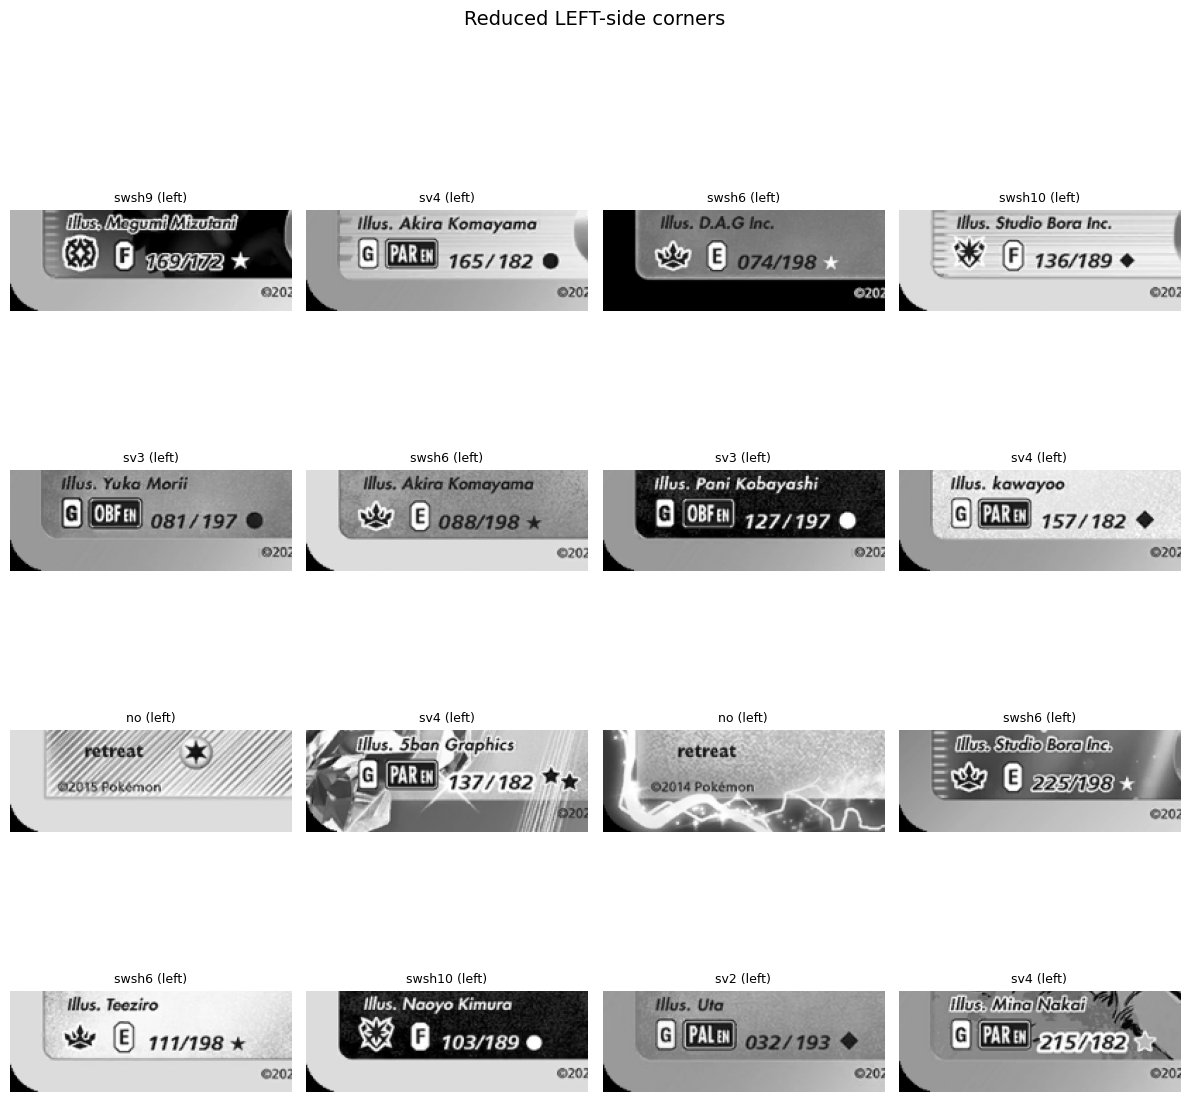

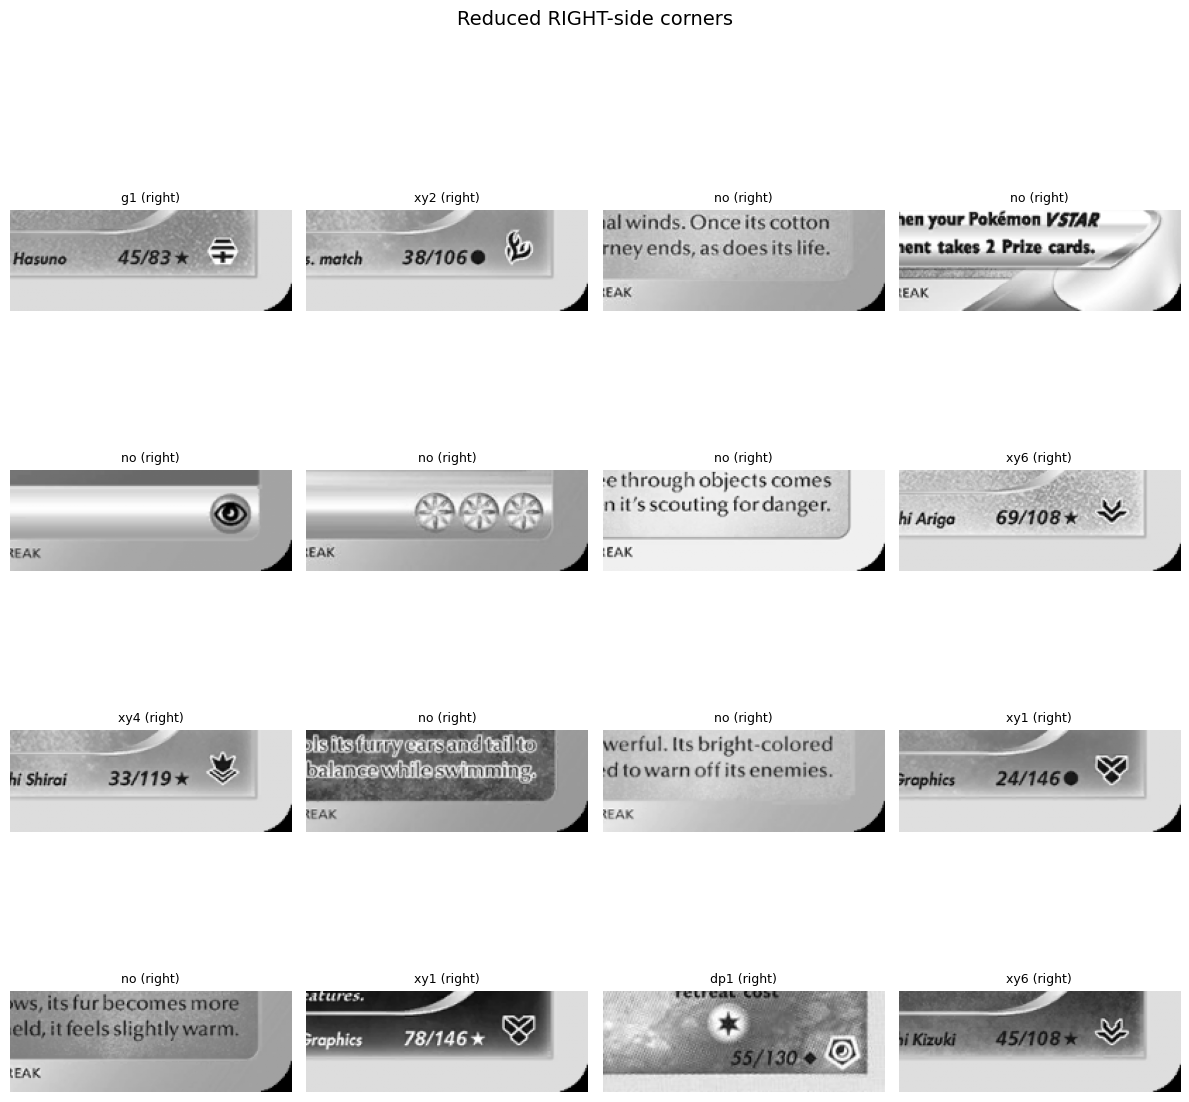

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1) Load left- and right-side datasets
df_left  = pd.read_json("raw_data_reduced/dict_reduceddataset_left.json")
df_right = pd.read_json("raw_data_reduced/dict_reduceddataset_right.json")

# 2) Rehydrate the image arrays
for df in (df_left, df_right):
    df['corner'] = df['corner'].apply(lambda lst: np.array(lst, dtype=np.uint8))

# 3) Helper to plot a few samples from any df
def show_samples(df, title, n=16, ncols=4):
    sample = df.sample(n, random_state=0).reset_index(drop=True)
    nrows = (n + ncols - 1)//ncols
    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*3, nrows*3))
    axes = axes.flatten()
    for ax, (_, row) in zip(axes, sample.iterrows()):
        ax.imshow(row['corner'], cmap='gray')
        ax.set_title(f"{row['set_id']} ({row['position']})", fontsize=9)
        ax.axis('off')
    # blank out any extra axes
    for ax in axes[len(sample):]:
        ax.axis('off')
    fig.suptitle(title, y=1.02, fontsize=14)
    plt.tight_layout()
    plt.show()

# 4) Peek at each
show_samples(df_left,  "Reduced LEFT-side corners")
show_samples(df_right, "Reduced RIGHT-side corners")


In [ ]:
import pandas as pd
import numpy as np
from model.augmentation import get_augment_data

# 1) Load your two raw JSONs
df_left  = pd.read_json("raw_data_reduced/dict_reduceddataset_left.json")
df_right = pd.read_json("raw_data_reduced/dict_reduceddataset_right.json")

# 2) Inject a unique orig_id per row (across both sides)
df_left["orig_id"]  = np.arange(len(df_left))
df_right["orig_id"] = np.arange(len(df_left), len(df_left) + len(df_right))

# 3) Save these augmented-with-IDs files so your augmenter can read them
df_left.to_json("raw_data_reduced/left_with_id.json", orient="records")
df_right.to_json("raw_data_reduced/right_with_id.json", orient="records")

# 4) Now call your augmenter on the _new_ files
df_left_aug  = get_augment_data("raw_data_reduced/left_with_id.json")
df_right_aug = get_augment_data("raw_data_reduced/right_with_id.json")

# 5) Concatenate, shuffle, and then split on orig_id
df_all = pd.concat([df_left_aug, df_right_aug], ignore_index=True)
unique_ids = df_all["orig_id"].unique()
np.random.seed(42)
np.random.shuffle(unique_ids)

n = len(unique_ids)
n_train = int(0.7 * n)
n_val   = int(0.85 * n)

train_ids = unique_ids[:n_train]
val_ids   = unique_ids[n_train:n_val]
test_ids  = unique_ids[n_val:]

df_train = df_all[df_all["orig_id"].isin(train_ids)]
df_val   = df_all[df_all["orig_id"].isin(val_ids)]
df_test  = df_all[df_all["orig_id"].isin(test_ids)]

# Now df_train/df_val/df_test have no leakage: all augments of any orig_id stay together.


In [10]:
# assuming train_ids, val_ids, test_ids are in scope
print("Train∩Val:",  len(set(train_ids) & set(val_ids)))
print("Train∩Test:", len(set(train_ids) & set(test_ids)))
print("Val∩Test:",   len(set(val_ids)   & set(test_ids)))
# all should be 0


Train∩Val: 0
Train∩Test: 0
Val∩Test: 0


In [11]:
print("Train rows:", df_train.shape[0],  "unique originals:", df_train["orig_id"].nunique())
print(" Val  rows:", df_val.shape[0],    "unique originals:", df_val["orig_id"].nunique())
print("Test  rows:", df_test.shape[0],   "unique originals:", df_test["orig_id"].nunique())

print("Train class dist:\n", df_train["set_id"].value_counts())
print(" Val  class dist:\n", df_val["set_id"].value_counts())


Train rows: 15268 unique originals: 2822
 Val  rows: 3308 unique originals: 605
Test  rows: 3424 unique originals: 605
Train class dist:
 set_id
no           1367
swsh9         778
dp2           765
xy7           743
xy2           738
sv3           737
dp1           733
sm4           722
xy6           715
swsh12pt5     713
sv4           710
swsh10        703
swsh45        696
xy1           689
xy3           682
sv3pt5        681
g1            680
sv2           680
xy4           669
swsh6         667
dv1           400
Name: count, dtype: int64
 Val  class dist:
 set_id
no           339
dv1          284
swsh6        203
xy3          174
sv3pt5       171
g1           170
swsh12pt5    167
swsh45       154
xy2          153
sv2          147
sv4          140
sv3          136
sm4          135
dp2          133
dp1          129
xy1          128
swsh10       119
xy6          117
xy7          110
swsh9        101
xy4           98
Name: count, dtype: int64


In [12]:
import numpy as np
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from model.modelling import make_dataset, build_cnn
from tensorflow.keras import callbacks
from model import HARD_CODED_WIDTH, HARD_CODED_HEIGHT

# ─── 1) Prepare X/Y arrays from your df_train, df_val, df_test ─────────────────

def df_to_arrays(df):
    # stack + normalize
    X = np.stack(df["corner"].values, axis=0).astype("float32") / 255.0
    if X.ndim == 3:
        X = X[..., np.newaxis]
    # encode labels
    le = LabelEncoder().fit(df_train["set_id"])   # fit on train only
    y_int = le.transform(df["set_id"])
    y = to_categorical(y_int)
    return X, y, le

X_train, y_train, le = df_to_arrays(df_train)
X_val,   y_val,   _  = df_to_arrays(df_val)
X_test,  y_test,  _  = df_to_arrays(df_test)

# ─── 2) Wrap in tf.data pipelines ────────────────────────────────────────────
batch_size = 16
train_ds = make_dataset(X_train, y_train, batch_size, training=True)
val_ds   = make_dataset(X_val,   y_val,   batch_size, training=False)
test_ds  = make_dataset(X_test,  y_test,  batch_size, training=False)

# ─── 3) Build, compile & callbacks ──────────────────────────────────────────
input_shape = (HARD_CODED_HEIGHT, HARD_CODED_WIDTH, 1)
model = build_cnn(input_shape, num_classes=y_train.shape[1])
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)
cbs = [
    callbacks.EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True),
    callbacks.ModelCheckpoint("best_symbols_model.h5", save_best_only=True)
]

# ─── 4) Train & evaluate ─────────────────────────────────────────────────────
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=cbs,
    verbose=1
)

# final test metrics
test_loss, test_acc = model.evaluate(test_ds, verbose=0)
print(f"Test accuracy: {test_acc:.4f}, loss: {test_loss:.4f}")


Epoch 1/20


/Users/pavelsingh/.pyenv/versions/3.10.6/envs/Pokemon/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


954/955 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.5241 - loss: 1.5187

955/955 ━━━━━━━━━━━━━━━━━━━━ 98s 101ms/step - accuracy: 0.5246 - loss: 1.5171 - val_accuracy: 0.9595 - val_loss: 0.6668
Epoch 2/20
954/955 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.9955 - loss: 0.0456

955/955 ━━━━━━━━━━━━━━━━━━━━ 93s 97ms/step - accuracy: 0.9955 - loss: 0.0456 - val_accuracy: 0.9652 - val_loss: 0.1893
Epoch 3/20
954/955 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.9962 - loss: 0.0235

955/955 ━━━━━━━━━━━━━━━━━━━━ 88s 92ms/step - accuracy: 0.9962 - loss: 0.0235 - val_accuracy: 0.9770 - val_loss: 0.1648
Epoch 4/20
955/955 ━━━━━━━━━━━━━━━━━━━━ 89s 93ms/step - accuracy: 0.9999 - loss: 0.0061 - val_accuracy: 0.8322 - val_loss: 2.9680
Epoch 5/20
954/955 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.9844 - loss: 0.0644

955/955 ━━━━━━━━━━━━━━━━━━━━ 88s 93ms/step - accuracy: 0.9844 - loss: 0.0643 - val_accuracy: 0.9831 - val_loss: 0.0522
Epoch 6/20
955/955 ━━━━━━━━━━━━━━━━━━━━ 96s 101ms/step - accuracy: 0.9981 - loss: 0.0098 - val_accuracy: 0.6137 - val_loss: 6.9457
Epoch 7/20
955/955 ━━━━━━━━━━━━━━━━━━━━ 97s 102ms/step - accuracy: 0.9971 - loss: 0.0108 - val_accuracy: 0.9834 - val_loss: 0.0558
Epoch 8/20
955/955 ━━━━━━━━━━━━━━━━━━━━ 91s 95ms/step - accuracy: 0.9998 - loss: 0.0026 - val_accuracy: 0.8407 - val_loss: 0.4330
Test accuracy: 0.9810, loss: 0.0633


In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

# 1) Evaluate on the TRAINING set (inference mode, no dropout)
train_loss, train_acc = model.evaluate(train_ds, verbose=0)
print(f"Train   —  loss: {train_loss:.3f},  acc: {train_acc:.3f}")

# 2) Evaluate on the VALIDATION set
val_loss, val_acc = model.evaluate(val_ds, verbose=0)
print(f"Val     —  loss: {val_loss:.3f},  acc: {val_acc:.3f}\n")

# 3) Detailed per-class metrics on VAL
# (we already have `le` from your df_to_arrays, and `y_val` if still in scope)
y_val_true = np.argmax(y_val, axis=1)
y_val_pred = np.argmax(model.predict(val_ds), axis=1)

print("Classification Report (val):")
print(classification_report(y_val_true, y_val_pred, target_names=le.classes_))


Train   —  loss: 0.008,  acc: 0.999
Val     —  loss: 0.052,  acc: 0.983

207/207 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step
Classification Report (val):
              precision    recall  f1-score   support

         dp1       1.00      0.99      1.00       129
         dp2       1.00      0.99      1.00       133
         dv1       1.00      0.84      0.91       284
          g1       0.88      1.00      0.93       170
          no       0.95      1.00      0.98       339
         sm4       1.00      1.00      1.00       135
         sv2       0.99      1.00      0.99       147
         sv3       1.00      1.00      1.00       136
      sv3pt5       1.00      1.00      1.00       171
         sv4       1.00      0.98      0.99       140
      swsh10       1.00      1.00      1.00       119
   swsh12pt5       1.00      1.00      1.00       167
      swsh45       1.00      1.00      1.00       154
       swsh6       1.00      1.00      1.00       203
       swsh9       1.00      1.00      1.00  

In [14]:
print("Confusion Matrix (val):")
print(confusion_matrix(y_val_true, y_val_pred))

Confusion Matrix (val):
[[128   0   0   0   1   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0]
 [  0 132   0   0   1   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0]
 [  0   0 239  24  12   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   9]
 [  0   0   0 170   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0]
 [  0   0   0   0 339   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0]
 [  0   0   0   0   0 135   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0]
 [  0   0   0   0   0   0 147   0   0   0   0   0   0   0   0   0   0   0
    0   0   0]
 [  0   0   0   0   0   0   0 136   0   0   0   0   0   0   0   0   0   0
    0   0   0]
 [  0   0   0   0   0   0   0   0 171   0   0   0   0   0   0   0   0   0
    0   0   0]
 [  0   0   0   0   1   0   2   0   0 137   0   0   0   0   0   0   0   0
    0   0   0]
 [  0   0   0   0   0   0   0   0   0   0 119   0   0   0   0   0   0   0
    0   0   

In [15]:
# assuming train_ids, val_ids, test_ids are still in scope
print("Train ∩ Val:",   len(set(train_ids) & set(val_ids)))
print("Train ∩ Test:",  len(set(train_ids) & set(test_ids)))
print("Val   ∩ Test:",  len(set(val_ids)   & set(test_ids)))

# and how many unique originals ended up in each
print("Unique orig_ids →",
      "train:", df_train.orig_id.nunique(),
      "val:",   df_val.orig_id.nunique(),
      "test:",  df_test.orig_id.nunique())


Train ∩ Val: 0
Train ∩ Test: 0
Val   ∩ Test: 0
Unique orig_ids → train: 2822 val: 605 test: 605


In [11]:
import pandas as pd
df_augmented = pd.concat([df_left_aug, df_right_aug], ignore_index=True)


In [17]:
import pandas as pd

# 1) Load the full JSON
df = pd.read_json("raw_data/full_corners.json", orient="records")

# 2) Pull out the position column
pos = df["position"]

# 3) Look at counts on all even vs all odd indices
even_counts = pos.iloc[::2].value_counts()
odd_counts  = pos.iloc[1::2].value_counts()

print("Even-index positions (should all be 'left'):\n", even_counts, "\n")
print("Odd-index positions  (should all be 'right'):\n", odd_counts, "\n")

# 4) If you want to **fail** fast as soon as any mismatch appears:
mismatch_even = pos.iloc[::2] != "left"
mismatch_odd  = pos.iloc[1::2] != "right"

print("Any evens that aren’t 'left'? ", mismatch_even.any())
print("Any odds that aren’t 'right'? ", mismatch_odd.any())


Even-index positions (should all be 'left'):
 position
left    3032
Name: count, dtype: int64 

Odd-index positions  (should all be 'right'):
 position
right    3032
Name: count, dtype: int64 

Any evens that aren’t 'left'?  False
Any odds that aren’t 'right'?  False


In [18]:
import pandas as pd
import numpy as np

# 1) Load the full JSON into a DataFrame
df = pd.read_json("raw_data/full_corners.json", orient="records")

# 2) Assign orig_id = floor(row_index / 2)
df["orig_id"] = (np.arange(len(df)) // 2).astype(int)

# 3) Sanity-check grouping: each orig_id should have both {'left','right'}
grouped = df.groupby("orig_id")["position"].apply(lambda ps: set(ps))
bad = grouped[grouped != {"left", "right"}]
print("Mismatched groups (should be empty):")
print(bad.head())

# 4) Persist for augmentation
df.to_json("raw_data/full_with_card_id.json", orient="records", indent=2)
print("Written full_with_card_id.json with", len(df), "records, each paired by orig_id.")


Mismatched groups (should be empty):
Series([], Name: position, dtype: object)
Written full_with_card_id.json with 6064 records, each paired by orig_id.


In [19]:
import numpy as np
from model.augmentation import get_augment_data

# 5) Augment your paired dataset once
df_aug = get_augment_data("raw_data/full_with_card_id.json")

# 6) Shuffle and split on orig_id (70/15/15)
df_aug = df_aug.sample(frac=1, random_state=42).reset_index(drop=True)
unique_ids = df_aug["orig_id"].unique()
np.random.seed(42); np.random.shuffle(unique_ids)

n = len(unique_ids)
n_train = int(0.7 * n)
n_val   = int(0.85 * n)

train_ids = unique_ids[:n_train]
val_ids   = unique_ids[n_train:n_val]
test_ids  = unique_ids[n_val:]

df_train = df_aug[df_aug["orig_id"].isin(train_ids)]
df_val   = df_aug[df_aug["orig_id"].isin(val_ids)]
df_test  = df_aug[df_aug["orig_id"].isin(test_ids)]

# 7) Quick sanity checks
print("Total augmented samples:", len(df_aug))
print("Train / Val / Test shapes:", df_train.shape, df_val.shape, df_test.shape)

print("\nOverlap checks (should all be 0):")
print("Train ∩ Val:",  len(set(train_ids) & set(val_ids)))
print("Train ∩ Test:", len(set(train_ids) & set(test_ids)))
print("Val   ∩ Test:", len(set(val_ids)   & set(test_ids)))


Total augmented samples: 23032
Train / Val / Test shapes: (16471, 5) (3362, 5) (3199, 5)

Overlap checks (should all be 0):
Train ∩ Val: 0
Train ∩ Test: 0
Val   ∩ Test: 0


In [20]:
import numpy as np
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import callbacks
from model.modelling import make_dataset, build_cnn
from model import HARD_CODED_WIDTH, HARD_CODED_HEIGHT

# 1) Helper to turn a df into X, y, and (for train) a LabelEncoder
def df_to_arrays(df, le=None):
    X = np.stack(df["corner"].values, axis=0).astype("float32") / 255.0
    if X.ndim == 3:
        X = X[..., np.newaxis]
    if le is None:
        # fit only on train labels
        le = LabelEncoder().fit(df_train["set_id"])
    y_int = le.transform(df["set_id"])
    y = to_categorical(y_int)
    return X, y, le

# 2) Build arrays
X_train, y_train, le = df_to_arrays(df_train)
X_val,   y_val,   _  = df_to_arrays(df_val,   le)
X_test,  y_test,  _  = df_to_arrays(df_test,  le)

# 3) Wrap in tf.data
train_ds = make_dataset(X_train, y_train, batch_size=16, training=True)
val_ds   = make_dataset(X_val,   y_val,   batch_size=16, training=False)
test_ds  = make_dataset(X_test,  y_test,  batch_size=16, training=False)

# 4) Build & compile your CNN
model = build_cnn((HARD_CODED_HEIGHT, HARD_CODED_WIDTH, 1), y_train.shape[1])
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)
cbs = [
    callbacks.EarlyStopping("val_loss", patience=3, restore_best_weights=True),
    callbacks.ModelCheckpoint("best_symbols_model.h5", save_best_only=True)
]

# 5) Train!
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=cbs,
    verbose=1
)

# 6) Final evaluation
test_loss, test_acc = model.evaluate(test_ds, verbose=0)
print(f"Test accuracy: {test_acc:.4f}, loss: {test_loss:.4f}")


Epoch 1/20


/Users/pavelsingh/.pyenv/versions/3.10.6/envs/Pokemon/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1029/1030 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.6818 - loss: 1.1329

1030/1030 ━━━━━━━━━━━━━━━━━━━━ 99s 94ms/step - accuracy: 0.6821 - loss: 1.1318 - val_accuracy: 0.9584 - val_loss: 0.1583
Epoch 2/20
1029/1030 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.9861 - loss: 0.0693

1030/1030 ━━━━━━━━━━━━━━━━━━━━ 99s 96ms/step - accuracy: 0.9861 - loss: 0.0692 - val_accuracy: 0.9851 - val_loss: 0.1359
Epoch 3/20
1030/1030 ━━━━━━━━━━━━━━━━━━━━ 96s 93ms/step - accuracy: 0.9956 - loss: 0.0250 - val_accuracy: 0.9634 - val_loss: 0.1505
Epoch 4/20
1029/1030 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.9949 - loss: 0.0242

1030/1030 ━━━━━━━━━━━━━━━━━━━━ 94s 91ms/step - accuracy: 0.9949 - loss: 0.0242 - val_accuracy: 0.9887 - val_loss: 0.1286
Epoch 5/20
1030/1030 ━━━━━━━━━━━━━━━━━━━━ 101s 98ms/step - accuracy: 0.9966 - loss: 0.0147 - val_accuracy: 0.9301 - val_loss: 0.2679
Epoch 6/20
1030/1030 ━━━━━━━━━━━━━━━━━━━━ 98s 95ms/step - accuracy: 0.9963 - loss: 0.0161 - val_accuracy: 0.9111 - val_loss: 0.3312
Epoch 7/20
1029/1030 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.9937 - loss: 0.0246

1030/1030 ━━━━━━━━━━━━━━━━━━━━ 95s 92ms/step - accuracy: 0.9937 - loss: 0.0246 - val_accuracy: 0.9590 - val_loss: 0.1233
Epoch 8/20
1029/1030 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.9977 - loss: 0.0090

1030/1030 ━━━━━━━━━━━━━━━━━━━━ 98s 95ms/step - accuracy: 0.9977 - loss: 0.0090 - val_accuracy: 0.9943 - val_loss: 0.0839
Epoch 9/20
1029/1030 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.9985 - loss: 0.0063

1030/1030 ━━━━━━━━━━━━━━━━━━━━ 95s 92ms/step - accuracy: 0.9985 - loss: 0.0063 - val_accuracy: 0.9961 - val_loss: 0.0124
Epoch 10/20
1030/1030 ━━━━━━━━━━━━━━━━━━━━ 96s 93ms/step - accuracy: 0.9972 - loss: 0.0094 - val_accuracy: 0.9533 - val_loss: 0.1476
Epoch 11/20
1030/1030 ━━━━━━━━━━━━━━━━━━━━ 92s 89ms/step - accuracy: 0.9980 - loss: 0.0079 - val_accuracy: 0.9908 - val_loss: 0.0244
Epoch 12/20
1030/1030 ━━━━━━━━━━━━━━━━━━━━ 91s 88ms/step - accuracy: 0.9979 - loss: 0.0077 - val_accuracy: 0.9958 - val_loss: 0.0141
Test accuracy: 0.9966, loss: 0.0075


In [21]:
train_loss, train_acc = model.evaluate(train_ds, verbose=0)
val_loss,   val_acc   = model.evaluate(val_ds,   verbose=0)
print(f"Train acc: {train_acc:.3f},  Val acc: {val_acc:.3f}")
# expect both in the ~0.99 range now


Train acc: 1.000,  Val acc: 0.996


In [22]:
# After training:
print(f"Epoch 1 — train acc: {history.history['accuracy'][0]:.4f}, "
      f"val acc: {history.history['val_accuracy'][0]:.4f}")


Epoch 1 — train acc: 0.8445, val acc: 0.9584


In [23]:
train_loss, train_acc = model.evaluate(train_ds, verbose=0)
val_loss,   val_acc   = model.evaluate(val_ds,   verbose=0)
print(f"Inference-mode →  Train acc: {train_acc:.4f},  Val acc: {val_acc:.4f}")


Inference-mode →  Train acc: 0.9998,  Val acc: 0.9961


In [24]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

# 1) Overall accuracy & loss
test_loss, test_acc = model.evaluate(test_ds, verbose=0)
print(f"Test   —  loss: {test_loss:.4f},  acc: {test_acc:.4f}")

# 2) Per-class precision/recall
#    (y_test was your one-hot labels; df_test["set_id"] holds the true set names)
y_true = np.argmax(y_test, axis=1)
y_pred = np.argmax(model.predict(test_ds), axis=1)

print("Classification report on test set:\n")
print(classification_report(y_true, y_pred, target_names=le.classes_))

# 3) Confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion matrix:\n", cm)


Test   —  loss: 0.0075,  acc: 0.9966
200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step
Classification report on test set:

              precision    recall  f1-score   support

         dp1       1.00      1.00      1.00        74
         dp2       1.00      1.00      1.00        71
         dv1       1.00      1.00      1.00        17
          g1       1.00      1.00      1.00        80
          no       1.00      1.00      1.00      1613
         sm4       1.00      1.00      1.00        56
         sv2       1.00      1.00      1.00        95
         sv3       1.00      1.00      1.00        80
      sv3pt5       1.00      1.00      1.00        64
         sv4       1.00      1.00      1.00       109
      swsh10       1.00      0.99      1.00       129
   swsh12pt5       0.99      1.00      1.00       113
      swsh45       1.00      1.00      1.00        34
       swsh6       1.00      1.00      1.00        86
       swsh9       1.00      1.00      1.00        53
         xy1       0

In [ ]:
from model.deformer import deform_card
import pickle, cv2, numpy as np
from PIL import Image
from tensorflow.keras.models import load_model

# Load model & encoder
model = load_model("best_symbols_model.h5")
with open("label_encoder.pkl", "rb") as f:
    le = pickle.load(f)

# Reuse your functions
def extract_corner(img_path):
    pil = Image.open(img_path)
    warped = deform_card(pil)
    gray = cv2.cvtColor(warped, cv2.COLOR_RGB2GRAY)
    h, w = gray.shape
    left  = gray[h-72:h,     0:200]
    right = gray[h-72:h, w-200:w]
    def prep(x):
        x = x.astype("float32")/255.0
        return x.reshape((1,72,200,1))
    return prep(left), prep(right)

def predict_card_from_full_image(img_path):
    xL, xR = extract_corner(img_path)
    p = (model.predict(xL)[0] + model.predict(xR)[0]) / 2
    idx = np.argmax(p)
    return le.inverse_transform([idx])[0], p[idx]

path = "images_example/IMG_9398.jpg"
pred, conf = predict_card_from_full_image(path)
print(f"{path} → {pred} ({conf*100:.1f}% confidence)")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
images_example/IMG_9398.jpg → no (100.0% confidence)


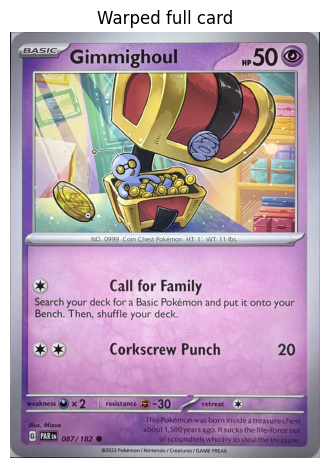

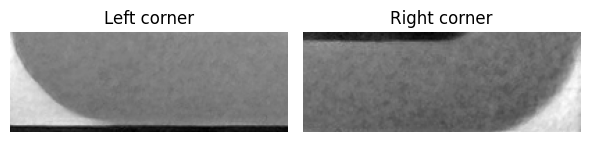

In [35]:
import matplotlib.pyplot as plt

# 1) Load and warp the full card
pil = Image.open("/Users/pavelsingh/Desktop/IMG_9398.jpg")
warped = deform_card(pil)

# 2) Show the straightened card
plt.figure(figsize=(4,6))
plt.imshow(warped)
plt.title("Warped full card")
plt.axis('off')
plt.show()

# 3) Extract the two corners
left, right = extract_corner("/Users/pavelsingh/Desktop/IMG_9398.jpg")

# 4) Visualize them
fig, axes = plt.subplots(1,2, figsize=(6,3))
axes[0].imshow(left[0,:,:,0], cmap='gray');  axes[0].set_title("Left corner")
axes[1].imshow(right[0,:,:,0], cmap='gray'); axes[1].set_title("Right corner")
for ax in axes: ax.axis('off')
plt.tight_layout()
plt.show()


In [ ]:
import glob
import pickle
import numpy as np
import cv2
from tensorflow.keras.models import load_model
from PIL import Image

from model.deformer import deform_card              # your full-card warp
from model.prediction import card_prediction_processing  # your helper

# 1) Load model + label encoder
model = load_model("best_symbols_model.h5")
with open("label_encoder.pkl","rb") as f:
    le = pickle.load(f)

# 2) Full-pipeline: warp → corner crops → predict
def predict_card_from_full_image(img_path):
    # a) Read & warp to get a straight RGB image
    pil = Image.open(img_path)
    warped = deform_card(pil)            # H×W×3 RGB NumPy array

    # b) Extract bottom-left & bottom-right corners
    #    shapes: (1, HARD_CODED_HEIGHT, HARD_CODED_WIDTH, 1)
    xL, xR = card_prediction_processing(warped)

    # c) Run both through the model and average
    pL = model.predict(xL, verbose=0)[0]
    pR = model.predict(xR, verbose=0)[0]
    p  = (pL + pR) / 2

    # d) Decode prediction
    idx  = np.argmax(p)
    name = le.inverse_transform([idx])[0]
    conf = p[idx]
    return name, conf

# 3) Run on your Desktop JPEGs

path = "images_example/IMG_9400.jpg"
pred, conf = predict_card_from_full_image(path)
print(f"{path} → {pred} ({conf*100:.1f}% confidence)")


images_example/IMG_9400.jpg → no (50.0% confidence)


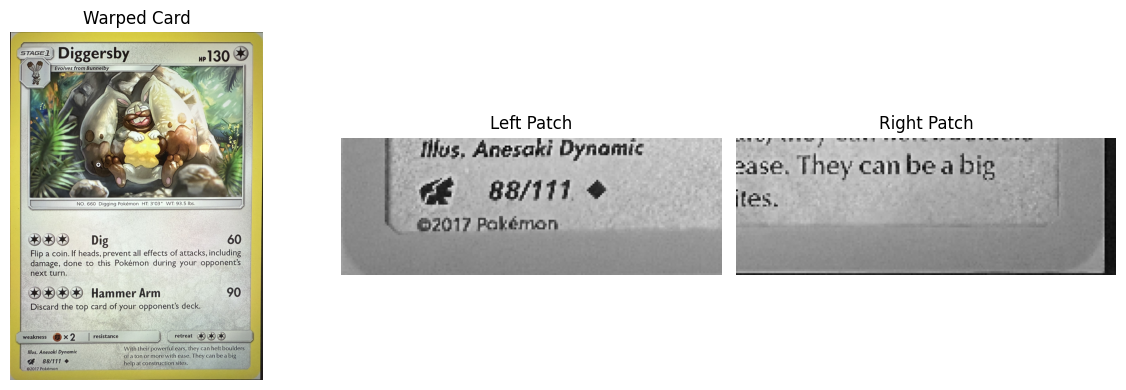

images_example/IMG_9399.jpg → no  (50.0% confidence)


In [41]:
import matplotlib.pyplot as plt

def predict_and_show(img_path):
    # 1) Warp full card
    pil    = Image.open(img_path)
    warped = deform_card(pil)            # H×W×3 RGB array

    # 2) Crop & preprocess corners
    xL, xR = card_prediction_processing(warped)  # each is shape (1,72,200,1)

    # 3) Convert back to uint8 for display
    left_patch  = (xL[0, ..., 0] * 255).astype("uint8")
    right_patch = (xR[0, ..., 0] * 255).astype("uint8")

    # 4) Plot warped + both corners
    fig, axes = plt.subplots(1,3, figsize=(12,4))
    axes[0].imshow(warped); axes[0].set_title("Warped Card"); axes[0].axis("off")
    axes[1].imshow(left_patch,  cmap="gray"); axes[1].set_title("Left Patch");  axes[1].axis("off")
    axes[2].imshow(right_patch, cmap="gray"); axes[2].set_title("Right Patch"); axes[2].axis("off")
    plt.tight_layout()
    plt.show()

    # 5) Run the model
    pL = model.predict(xL, verbose=0)[0]
    pR = model.predict(xR, verbose=0)[0]
    p  = (pL + pR) / 2

    # 6) Decode
    idx  = np.argmax(p)
    name = le.inverse_transform([idx])[0]
    conf = p[idx]
    print(f"{img_path} → {name}  ({conf*100:.1f}% confidence)")

# Usage:
predict_and_show("images_example/IMG_9399.jpg")


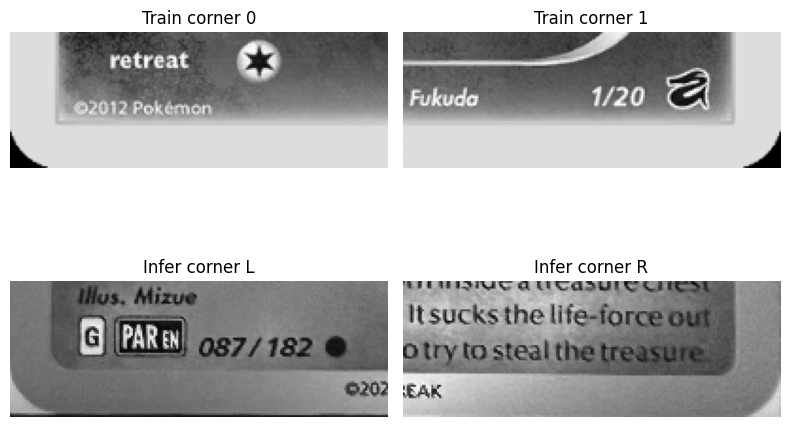

In [ ]:
import json
import numpy as np
import matplotlib.pyplot as plt

# 1) Load a small sample of your training-corner JSON
with open("raw_data/full_with_card_id.json","r") as f:
    raw = json.load(f)
# take the very first two corners
corners = [np.array(raw[i]["corner"]) for i in (0,1)]

# 2) Run your inference pipeline on the same original full image
#    (pick one of the real photos you used to generate raw_data)
original_full = "images_example/IMG_9398.jpg"
pil = Image.open(original_full)
warped = deform_card(pil)
inf_L, inf_R = card_prediction_processing(warped)

# 3) Plot them
fig, axes = plt.subplots(2, 2, figsize=(8,6))
axes[0,0].imshow(corners[0].squeeze(), cmap="gray"); axes[0,0].set_title("Train corner 0")
axes[0,1].imshow(corners[1].squeeze(), cmap="gray"); axes[0,1].set_title("Train corner 1")
axes[1,0].imshow(inf_L[0,...,0],       cmap="gray"); axes[1,0].set_title("Infer corner L")
axes[1,1].imshow(inf_R[0,...,0],       cmap="gray"); axes[1,1].set_title("Infer corner R")
for ax in axes.flatten(): ax.axis("off")
plt.tight_layout()
plt.show()


In [52]:
from model.deformer import deform_card
import cv2
import numpy as np

def extract_corners_from_full_card(img_path):
    # 1) Warp to hi-res dims
    from PIL import Image
    pil    = Image.open(img_path)
    warped = deform_card(pil)         # shape: (HIRES_H, HIRES_W, 3)

    # 2) Convert to grayscale
    gray = cv2.cvtColor(warped, cv2.COLOR_RGB2GRAY)
    H, W = gray.shape

    # 3) Use the exact same pixel indices you used in preprocessing:
    #    for example, if you originally did y0=738:y1=810 and x0=0:x1=200 etc.
    #    (you can recompute them from your JSON-building script)
    y0, y1 = 738, 810     # (example values; plug in your real ones)
    xL0, xL1 = 0, 200
    xR0, xR1 = W-200, W

    left  = gray[y0:y1, xL0:xL1]
    right = gray[y0:y1, xR0:xR1]

    # 4) Normalize & reshape
    left  = left .astype("float32")/255.0
    right = right.astype("float32")/255.0
    left  = left [np.newaxis, ..., np.newaxis]
    right = right[np.newaxis, ..., np.newaxis]

    return left, right


In [53]:
xL, xR = extract_corners_from_full_card(path)
p = (model.predict(xL)[0] + model.predict(xR)[0]) / 2


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


In [ ]:
import pandas as pd
import numpy as np
from model.augmentation import get_augment_data

# 1) Load both halves
df_left  = pd.read_json("raw_data_reduced/dict_reduceddataset_left.json")
df_right = pd.read_json("raw_data_reduced/dict_reduceddataset_right.json")

# 2) Assign the *same* orig_id to matching halves
n = len(df_left)  # must equal len(df_right)
ids = np.arange(n)
df_left["orig_id"]  = ids
df_right["orig_id"] = ids

# 3) Combine and persist for augmentation
df_raw = pd.concat([df_left, df_right], ignore_index=True)
df_raw.to_json("raw_data_reduced/raw_with_card_id.json", orient="records")

# 4) Augment your merged dataset once
df_aug = get_augment_data("raw_data_reduced/raw_with_card_id.json")

# 5) Shuffle and split ON orig_id (70/15/15)
df_aug = df_aug.sample(frac=1, random_state=42).reset_index(drop=True)
unique_ids = df_aug["orig_id"].unique()
np.random.seed(42); np.random.shuffle(unique_ids)

n = len(unique_ids)
n_train = int(0.7 * n)
n_val   = int(0.85 * n)

train_ids = unique_ids[:n_train]
val_ids   = unique_ids[n_train:n_val]
test_ids  = unique_ids[n_val:]

df_train = df_aug[df_aug["orig_id"].isin(train_ids)]
df_val   = df_aug[df_aug["orig_id"].isin(val_ids)]
df_test  = df_aug[df_aug["orig_id"].isin(test_ids)]

# Now df_train/df_val/df_test have no leakage—
# both halves (and all augmentations) of any card stay together.


ValueError: Length of values (2474) does not match length of index (1558)

In [12]:
# How many samples per set_id in each augmented DF?
print(df_left_aug['set_id'].value_counts())
print(df_right_aug['set_id'].value_counts())


set_id
no           1000
sm4          1000
sv2          1000
sv3          1000
sv3pt5       1000
sv4          1000
swsh10       1000
swsh12pt5    1000
swsh45       1000
swsh6        1000
swsh9        1000
Name: count, dtype: int64
set_id
dp1    1000
dp2    1000
dv1    1000
g1     1000
no     1000
xy1    1000
xy2    1000
xy3    1000
xy4    1000
xy6    1000
xy7    1000
Name: count, dtype: int64


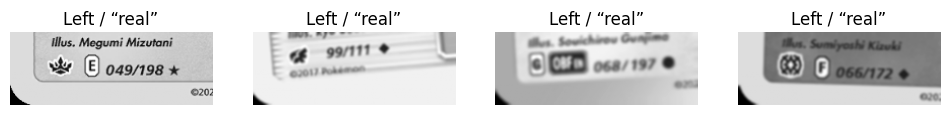

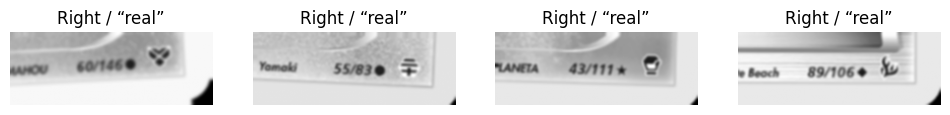

In [13]:
import matplotlib.pyplot as plt

# 4 random real left-side corners
real_left = df_left_aug[df_left_aug.set_id != 'no'].sample(4, random_state=4)['corner']
fig, axes = plt.subplots(1, 4, figsize=(12, 3))
for ax, img in zip(axes, real_left):
    ax.imshow(img.squeeze(), cmap='gray')
    ax.set_title("Left / “real”")
    ax.axis('off')
plt.show()

# 4 random real right-side corners
real_right = df_right_aug[df_right_aug.set_id != 'no'].sample(4, random_state=4)['corner']
fig, axes = plt.subplots(1, 4, figsize=(12, 3))
for ax, img in zip(axes, real_right):
    ax.imshow(img.squeeze(), cmap='gray')
    ax.set_title("Right / “real”")
    ax.axis('off')
plt.show()


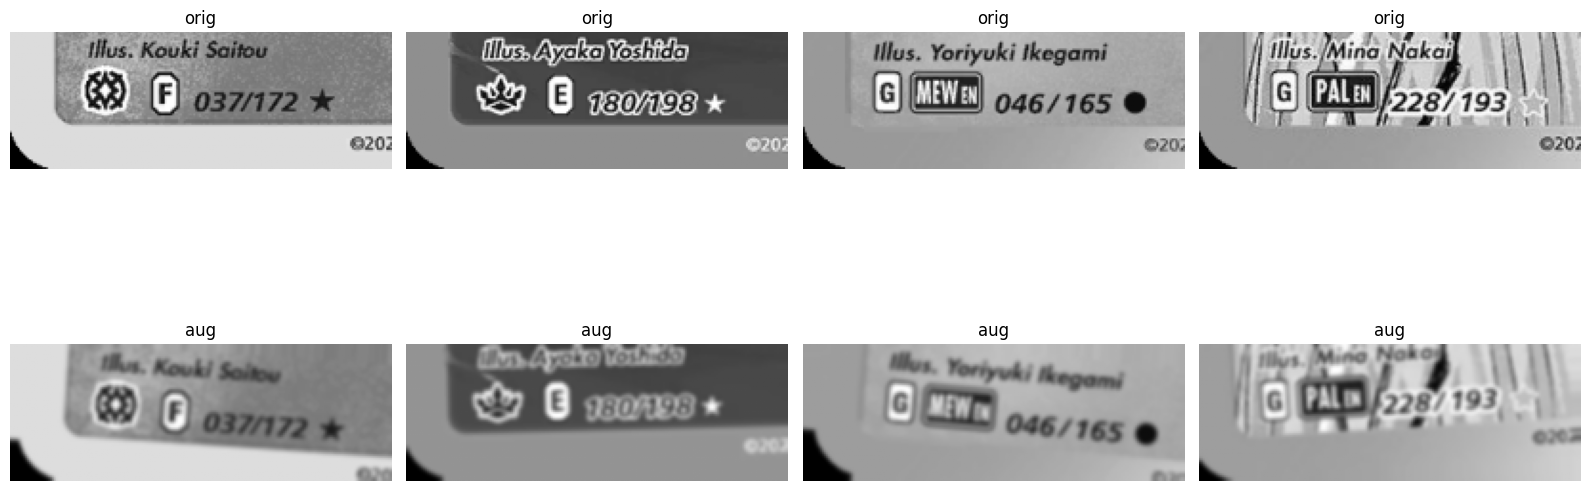

In [14]:
import matplotlib.pyplot as plt

# 1) grab 4 real left‐side corners
real = df_left[df_left.set_id != 'no'].sample(4, random_state=42)['corner'].to_list()

# 2) import your albumentation pipeline helpers
from model.augmentation import transform_array, generate_augmented_image, squeeze_photo

# 3) build a 2×4 grid
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
for i, orig in enumerate(real):
    # show the original
    axes[0, i].imshow(orig.squeeze(), cmap='gray')
    axes[0, i].set_title("orig")
    axes[0, i].axis('off')

    # run *that* one through your augmentation
    arr = transform_array(orig)             # → (1, H, W, 1)
    aug = generate_augmented_image(arr)     # → (H, W, 1)
    aug = squeeze_photo(aug)               # → (H, W, 1)

    # plot the augmented
    axes[1, i].imshow(aug.squeeze(), cmap='gray')
    axes[1, i].set_title("aug")
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()


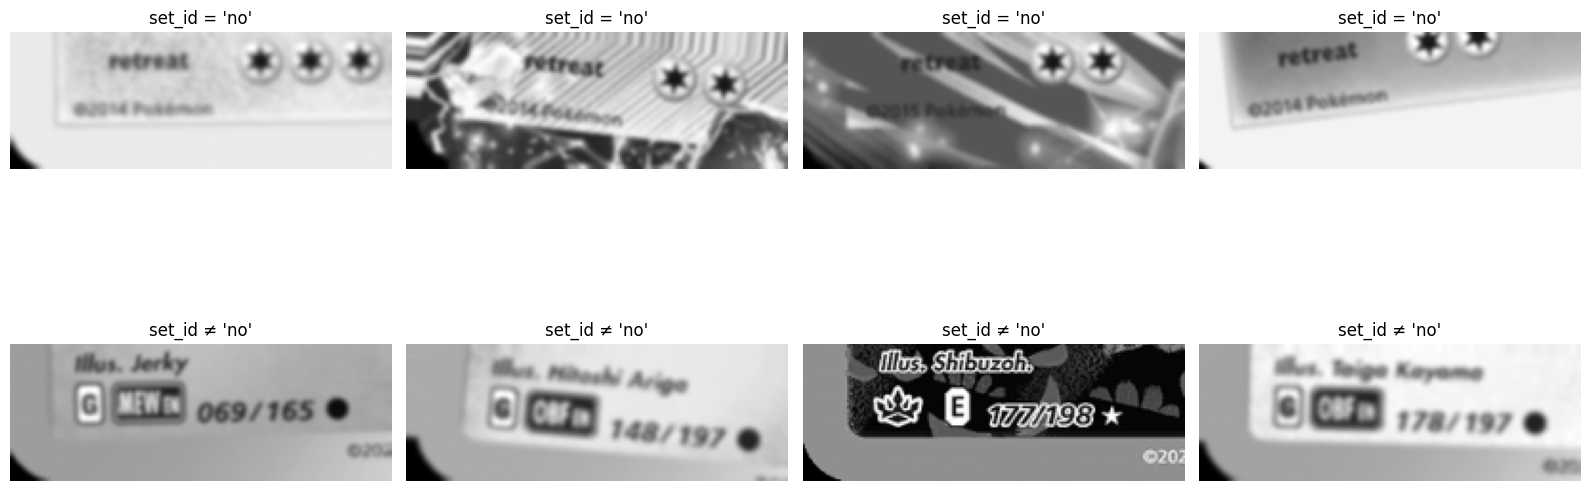

In [16]:
import matplotlib.pyplot as plt

# pick 4 “real” and 4 “no” from the left‐side augmented set
real_left = df_left_aug[df_left_aug.set_id != 'no'].sample(4, random_state=42)['corner'].to_list()
no_left   = df_left_aug[df_left_aug.set_id == 'no'].sample(4, random_state=42)['corner'].to_list()

fig, axes = plt.subplots(2, 4, figsize=(16, 8))

for i in range(4):
    # originals labelled “no”
    axes[0, i].imshow(no_left[i].squeeze(), cmap='gray')
    axes[0, i].set_title("set_id = 'no'")
    axes[0, i].axis('off')

    # originals labelled real
    axes[1, i].imshow(real_left[i].squeeze(), cmap='gray')
    axes[1, i].set_title("set_id ≠ 'no'")
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()


In [17]:
from model import NB_CARDS_PER_SET

# count how many you have of each set_id after augmentation
left_counts  = df_left_aug['set_id'].value_counts()
right_counts = df_right_aug['set_id'].value_counts()

print("Left side counts after augmentation:\n", left_counts, "\n")
print("Right side counts after augmentation:\n", right_counts, "\n")

# if augmentation did its job, every count should be exactly NB_CARDS_PER_SET
assert (left_counts  == NB_CARDS_PER_SET).all()
assert (right_counts == NB_CARDS_PER_SET).all()
print("✅ All sets have been up-sampled to", NB_CARDS_PER_SET)


Left side counts after augmentation:
 set_id
no           1000
sm4          1000
sv2          1000
sv3          1000
sv3pt5       1000
sv4          1000
swsh10       1000
swsh12pt5    1000
swsh45       1000
swsh6        1000
swsh9        1000
Name: count, dtype: int64 

Right side counts after augmentation:
 set_id
dp1    1000
dp2    1000
dv1    1000
g1     1000
no     1000
xy1    1000
xy2    1000
xy3    1000
xy4    1000
xy6    1000
xy7    1000
Name: count, dtype: int64 

✅ All sets have been up-sampled to 1000


In [3]:
import pandas as pd
from model.augmentation import get_augment_data

# 1a. Reload (and re-augment) both sides
df_left_aug  = get_augment_data("raw_data_reduced/dict_reduceddataset_left.json")
df_right_aug = get_augment_data("raw_data_reduced/dict_reduceddataset_right.json")

# 1b. Concatenate
df_all = pd.concat([df_left_aug, df_right_aug], ignore_index=True)

# 1c. Shuffle
df_all = df_all.sample(frac=1, random_state=42).reset_index(drop=True)

# 3) (Optional) Down-sample to e.g. 200 rows for a smoke test
df_small = df_all.sample(n=200, random_state=42)

print("Working with", len(df_small), "samples out of", len(df_all))
print(df_small['set_id'].value_counts())


Working with 200 samples out of 22000
set_id
sv2          19
swsh6        17
no           16
dp1          16
sv4          12
g1           10
xy6          10
xy1          10
swsh10        9
xy4           9
xy3           9
dp2           9
swsh12pt5     7
swsh9         7
xy7           7
sv3pt5        7
dv1           6
sv3           6
swsh45        6
xy2           5
sm4           3
Name: count, dtype: int64


In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from model.modelling import make_dataset, build_cnn
from model import HARD_CODED_WIDTH, HARD_CODED_HEIGHT

# 1) Prepare X & y
#   (Assumes df_small already in scope)
X = np.stack(df_small['corner'].values, axis=0).astype(np.float32) / 255.0
if X.ndim == 3:
    X = X[..., np.newaxis]

le = LabelEncoder()
y_int = le.fit_transform(df_small['set_id'])
y = to_categorical(y_int)

# 2) Train/val/test split
N = X.shape[0]
n_train = int(0.70 * N)
n_val   = int(0.85 * N)

X_train, y_train = X[:n_train], y[:n_train]
X_val,   y_val   = X[n_train:n_val], y[n_train:n_val]
X_test,  y_test  = X[n_val:],    y[n_val:]

print("Shapes:",
      X_train.shape, y_train.shape,
      X_val.shape,   y_val.shape,
      X_test.shape,  y_test.shape)

# 3) Make tf.data pipelines
batch_size = 16
train_ds = make_dataset(X_train, y_train, batch_size, training=True)
val_ds   = make_dataset(X_val,   y_val,   batch_size, training=False)

# 4) Build & compile a tiny model
input_shape = (HARD_CODED_HEIGHT, HARD_CODED_WIDTH, 1)
num_classes = y_train.shape[1]
model = build_cnn(input_shape, num_classes)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 5) Run just one epoch to check speed & correctness
import time
t0 = time.time()
history = model.fit(train_ds, validation_data=val_ds, epochs=1, verbose=1)
print("1-epoch smoke test took", time.time() - t0, "sec")


Shapes: (140, 72, 200, 1) (140, 21) (30, 72, 200, 1) (30, 21) (30, 72, 200, 1) (30, 21)


/Users/pavelsingh/.pyenv/versions/3.10.6/envs/Pokemon/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 109ms/step - accuracy: 0.1314 - loss: 3.5184 - val_accuracy: 0.0667 - val_loss: 3.0529
1-epoch smoke test took 2.0903499126434326 sec


In [5]:
# assuming df_all is still in your session
print("Columns:", df_all.columns.tolist())

# pick the column that holds the original identifier (e.g. 'filename' or 'image_id')
orig_col = 'image_id'  # ← replace with whatever your identifier column is

print("Unique originals:", df_all[orig_col].nunique(), "total rows:", len(df_all))


Columns: ['corner', 'position', 'set_id', 'set_name']


KeyError: 'image_id'

In [20]:
df_all.to_json("raw_data/augmented_all.json", orient="records")


In [ ]:
import json
import random

# 1) Load the full augmented JSON
with open("raw_data/augmented_all.json", "r") as f:
    data = json.load(f)

# 2) Draw a random sample of 100 records
sample = random.sample(data, 100)

# 3) Write them out to a new file
with open("raw_data/sample100.json", "w") as f:
    json.dump(sample, f)

print("Wrote raw_data/sample100.json with", len(sample), "records")


In [24]:
from model.modelling import symbols_model

model, history, conf_matrix, label_encoder = symbols_model(
    "raw_data/augmented_all.json",
    batch_size=16,
    epochs=20
)


/Users/pavelsingh/.pyenv/versions/3.10.6/envs/Pokemon/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
962/963 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.5505 - loss: 1.4670

963/963 ━━━━━━━━━━━━━━━━━━━━ 89s 91ms/step - accuracy: 0.5510 - loss: 1.4654 - val_accuracy: 0.9903 - val_loss: 0.1269
Epoch 2/20
962/963 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.9973 - loss: 0.0354

963/963 ━━━━━━━━━━━━━━━━━━━━ 89s 92ms/step - accuracy: 0.9973 - loss: 0.0354 - val_accuracy: 0.9985 - val_loss: 0.0254
Epoch 3/20
962/963 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.9972 - loss: 0.0190

963/963 ━━━━━━━━━━━━━━━━━━━━ 89s 92ms/step - accuracy: 0.9972 - loss: 0.0190 - val_accuracy: 0.9982 - val_loss: 0.0140
Epoch 4/20
962/963 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.9983 - loss: 0.0095

963/963 ━━━━━━━━━━━━━━━━━━━━ 89s 92ms/step - accuracy: 0.9983 - loss: 0.0095 - val_accuracy: 0.9982 - val_loss: 0.0069
Epoch 5/20
963/963 ━━━━━━━━━━━━━━━━━━━━ 89s 92ms/step - accuracy: 0.9967 - loss: 0.0150 - val_accuracy: 0.9952 - val_loss: 0.0237
Epoch 6/20
963/963 ━━━━━━━━━━━━━━━━━━━━ 1084s 1s/step - accuracy: 0.9978 - loss: 0.0106 - val_accuracy: 0.9942 - val_loss: 0.0487
Epoch 7/20
963/963 ━━━━━━━━━━━━━━━━━━━━ 1068s 1s/step - accuracy: 0.9957 - loss: 0.0129 - val_accuracy: 0.9976 - val_loss: 0.0111
207/207 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step
Classification Report:
              precision    recall  f1-score   support

         dp1       1.00      1.00      1.00       151
         dp2       1.00      1.00      1.00       140
         dv1       1.00      1.00      1.00       155
          g1       1.00      1.00      1.00       145
          no       1.00      0.99      1.00       288
         sm4       0.99      1.00      1.00       132
         sv2       1.00      1.00      1.00    

In [25]:
from model.modelling import preprocessing
import numpy as np

# Load and split without fitting or training the model
X_train, y_train, X_val, y_val, X_test, y_test, le = preprocessing("raw_data/augmented_all.json")

# 1) Print shapes
print(f"X_train: {X_train.shape},  y_train: {y_train.shape}")
print(f"X_val:   {X_val.shape},  y_val:   {y_val.shape}")
print(f"X_test:  {X_test.shape},  y_test:  {y_test.shape}")

# 2) Print class counts in each split
train_counts = np.sum(y_train, axis=0)
val_counts   = np.sum(y_val,   axis=0)
print("Train class distribution:", dict(zip(le.classes_, train_counts.astype(int))))
print(" Val  class distribution:", dict(zip(le.classes_,   val_counts.astype(int))))


X_train: (15399, 72, 200, 1),  y_train: (15399, 21)
X_val:   (3301, 72, 200, 1),  y_val:   (3301, 21)
X_test:  (3300, 72, 200, 1),  y_test:  (3300, 21)
Train class distribution: {'dp1': 689, 'dp2': 713, 'dv1': 695, 'g1': 722, 'no': 1394, 'sm4': 717, 'sv2': 712, 'sv3': 695, 'sv3pt5': 689, 'sv4': 710, 'swsh10': 703, 'swsh12pt5': 671, 'swsh45': 677, 'swsh6': 694, 'swsh9': 688, 'xy1': 702, 'xy2': 704, 'xy3': 710, 'xy4': 688, 'xy6': 713, 'xy7': 713}
 Val  class distribution: {'dp1': 160, 'dp2': 147, 'dv1': 150, 'g1': 133, 'no': 318, 'sm4': 151, 'sv2': 147, 'sv3': 150, 'sv3pt5': 148, 'sv4': 147, 'swsh10': 149, 'swsh12pt5': 166, 'swsh45': 161, 'swsh6': 146, 'swsh9': 152, 'xy1': 145, 'xy2': 140, 'xy3': 135, 'xy4': 156, 'xy6': 150, 'xy7': 150}


In [ ]:
from model.augmentation import get_augment_data

# Load everything into a DataFrame
df = get_augment_data("raw_data/augmented_all.json")

# 1) Total number of samples
print("Total rows in df:", len(df))

# 2) What columns do we have?
print("Columns:", df.columns.tolist())

# 3) Peek at a few entries
print(df.head(5))
print(df.sample(5))


Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x1073d2f50>>
Traceback (most recent call last):
  File "/Users/pavelsingh/.pyenv/versions/3.10.6/envs/Pokemon/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


In [5]:
# this will load, augment, shuffle, split, and train
from model.modelling import symbols_model

# train on left+right combined
df_augmented.to_json("raw_data/augmented_all.json", orient="records")
model, history, cm, le = symbols_model("raw_data/augmented_all.json")


Epoch 1/20


/Users/pavelsingh/.pyenv/versions/3.10.6/envs/Pokemon/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


481/482 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.5840 - loss: 1.3909

482/482 ━━━━━━━━━━━━━━━━━━━━ 85s 175ms/step - accuracy: 0.5849 - loss: 1.3879 - val_accuracy: 0.2187 - val_loss: 3.0008
Epoch 2/20
481/482 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.9971 - loss: 0.0406

482/482 ━━━━━━━━━━━━━━━━━━━━ 84s 173ms/step - accuracy: 0.9971 - loss: 0.0405 - val_accuracy: 0.9970 - val_loss: 0.0356
Epoch 3/20
482/482 ━━━━━━━━━━━━━━━━━━━━ 90s 187ms/step - accuracy: 0.9998 - loss: 0.0103 - val_accuracy: 0.9927 - val_loss: 0.1437
Epoch 4/20
482/482 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.9996 - loss: 0.0092

482/482 ━━━━━━━━━━━━━━━━━━━━ 85s 176ms/step - accuracy: 0.9996 - loss: 0.0092 - val_accuracy: 0.9982 - val_loss: 0.0277
Epoch 5/20
481/482 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.9984 - loss: 0.0128

482/482 ━━━━━━━━━━━━━━━━━━━━ 82s 170ms/step - accuracy: 0.9984 - loss: 0.0128 - val_accuracy: 0.9988 - val_loss: 0.0103
Epoch 6/20
150/482 ━━━━━━━━━━━━━━━━━━━━ 57s 172ms/step - accuracy: 0.9991 - loss: 0.0053

KeyboardInterrupt: 

In [12]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, Sequential, callbacks
from sklearn.preprocessing import LabelEncoder

from model.augmentation import load_corner_dataframe, make_tf_dataset
from model import HARD_CODED_WIDTH, HARD_CODED_HEIGHT


In [14]:
# load the reduced JSON (one side at a time, e.g. left)
df = load_corner_dataframe("raw_data_reduced/dict_reduceddataset_left.json")

# shuffle
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# encode labels 0…K-1
le = LabelEncoder()
df['label'] = le.fit_transform(df['set_id'])

# split 70/15/15
N = len(df)
n1 = int(0.7 * N)
n2 = int(0.85 * N)

df_train = df.iloc[:n1]
df_val   = df.iloc[n1:n2]
df_test  = df.iloc[n2:]

print("train / val / test:", len(df_train), len(df_val), len(df_test))


train / val / test: 1731 371 372


In [15]:
batch_size = 32

train_ds = make_tf_dataset(df_train, batch_size=batch_size, shuffle=True)
val_ds   = make_tf_dataset(df_val,   batch_size=batch_size, shuffle=False)
test_ds  = make_tf_dataset(df_test,  batch_size=batch_size, shuffle=False)


In [17]:
# 1) Point to your reduced JSON for the left‐corner data
LEFT_JSON  = "raw_data_reduced/dict_reduceddataset_left.json"
RIGHT_JSON = "raw_data_reduced/dict_reduceddataset_right.json"

# 2) Import and run the trainer
from model.modelling import symbols_model

# Train on left corners
model_left, history_left, cm_left, le_left = symbols_model(LEFT_JSON,
                                                          batch_size=32,
                                                          epochs=20)
# You’ll see training/validation loss & accuracy printed, plus a confusion matrix and full classification report.

# If you want a separate model for right corners:
model_right, history_right, cm_right, le_right = symbols_model(RIGHT_JSON,
                                                              batch_size=32,
                                                              epochs=20)


Epoch 1/20


/Users/pavelsingh/.pyenv/versions/3.10.6/envs/Pokemon/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


54/55 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - accuracy: 0.6852 - loss: 1.1549

55/55 ━━━━━━━━━━━━━━━━━━━━ 11s 184ms/step - accuracy: 0.6916 - loss: 1.1339 - val_accuracy: 0.1321 - val_loss: 7.2421
Epoch 2/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 10s 183ms/step - accuracy: 1.0000 - loss: 0.0560 - val_accuracy: 0.1321 - val_loss: 9.8832
Epoch 3/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 10s 176ms/step - accuracy: 1.0000 - loss: 0.0235 - val_accuracy: 0.1321 - val_loss: 9.7504
Epoch 4/20
54/55 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 1.0000 - loss: 0.0158

55/55 ━━━━━━━━━━━━━━━━━━━━ 10s 174ms/step - accuracy: 1.0000 - loss: 0.0158 - val_accuracy: 0.1617 - val_loss: 4.5127
Epoch 5/20
54/55 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - accuracy: 1.0000 - loss: 0.0119

55/55 ━━━━━━━━━━━━━━━━━━━━ 10s 183ms/step - accuracy: 1.0000 - loss: 0.0118 - val_accuracy: 0.2776 - val_loss: 2.3665
Epoch 6/20
54/55 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - accuracy: 1.0000 - loss: 0.0101

55/55 ━━━━━━━━━━━━━━━━━━━━ 10s 185ms/step - accuracy: 1.0000 - loss: 0.0101 - val_accuracy: 0.3881 - val_loss: 2.2208
Epoch 7/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 11s 192ms/step - accuracy: 0.9881 - loss: 0.0856 - val_accuracy: 0.1321 - val_loss: 33.5866
Epoch 8/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 10s 181ms/step - accuracy: 0.9986 - loss: 0.0102 - val_accuracy: 0.1429 - val_loss: 30.0313
Epoch 9/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 10s 187ms/step - accuracy: 0.9699 - loss: 0.1601 - val_accuracy: 0.1914 - val_loss: 7.6649
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step
Classification Report:
              precision    recall  f1-score   support

          no       0.46      0.76      0.57        62
         sm4       1.00      0.12      0.21        17
         sv2       0.22      0.33      0.26        49
         sv3       0.59      0.54      0.57        35
      sv3pt5       0.92      0.39      0.55        31
         sv4       0.63      0.97      0.77        39
      swsh10       0.50      0.03      0.05        

/Users/pavelsingh/.pyenv/versions/3.10.6/envs/Pokemon/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/pavelsingh/.pyenv/versions/3.10.6/envs/Pokemon/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/pavelsingh/.pyenv/versions/3.10.6/envs/Pokemon/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this beh

Epoch 1/20


/Users/pavelsingh/.pyenv/versions/3.10.6/envs/Pokemon/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


34/35 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - accuracy: 0.4809 - loss: 1.8162

35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 188ms/step - accuracy: 0.4905 - loss: 1.7797 - val_accuracy: 0.0726 - val_loss: 6.8856
Epoch 2/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 185ms/step - accuracy: 0.9448 - loss: 0.2904 - val_accuracy: 0.0726 - val_loss: 8.7925
Epoch 3/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 179ms/step - accuracy: 0.9960 - loss: 0.0663 - val_accuracy: 0.0726 - val_loss: 9.0843
Epoch 4/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 174ms/step - accuracy: 0.9953 - loss: 0.0408 - val_accuracy: 0.0726 - val_loss: 8.2918
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Classification Report:
              precision    recall  f1-score   support

         dp1       0.00      0.00      0.00        15
         dp2       0.09      1.00      0.16        21
         dv1       0.00      0.00      0.00         1
          g1       0.00      0.00      0.00        10
          no       0.00      0.00      0.00        78
         xy1       0.00      0.00      0.00        18
         xy2       0.00      0.00      0.00        20
     

/Users/pavelsingh/.pyenv/versions/3.10.6/envs/Pokemon/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/pavelsingh/.pyenv/versions/3.10.6/envs/Pokemon/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/pavelsingh/.pyenv/versions/3.10.6/envs/Pokemon/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this beh